<font size = 10 > Project 1 </font>

<font size = 6> One-dimensional diffusion model for $CO_2$ absorption in the ocean <font>

<font size = 3 > In this project we create a simplified one-dimentional model for
the absorption of CO2 at the surface, dissolution in water and transport of mass down to deeper depths by diffusion.

To do this we use the Crank-Nicolson method to solve the PDE from the diffusion equation, with boundary conditions given by Fick’s law, where we assume a no flux boundary at the sea floor and a flux given by eq. (3) at the surface. We also use several simplifications due to the complexity of the ocean such as the ideal gas law, constant environmental factors such as wind speed and temperature and immediate transformation from CO2 to dissolved inorganic carbon (DIC) in the ocean surface.

We will refer to the project booklet[1] through out the entire project.



</font>

## Importing libraries

In [77]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from scipy.integrate import simps
from numba import jit

------

## Tri-Diagonal Matrix Algorithm (TDMA)

In [78]:
@jit(nopython = True)

# Solves Ax = d to find x, where A is a tridiagonal matrix and x and d are vectors.
def tdma_solver(a, b, c, d):
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

# Solves Ax = b to find x.
def tdma(A, b): 
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

-----

## Solving for concentration of DIC

We define a function that takes in the diffusivity (K), initial concentration (C0), flux matrix (S), numer of timesteps (T), number of depth steps (N) and constants alpha and gamma. It creates the L and R matrices and solves equation (23) found in Appendix 2 using the Crank-Nicholson method.

In [79]:
def diff_solver(K, C0, S,T,N,alpha,gamma):
    
    # Creates L_main, L_upper, L_lower and R_main.
    L_main = np.ones(N+1) 
    R_main = np.ones(N+1) 
    L_upper = np.ones(N)  
    L_lower = np.ones(N)
    
    # Fills the main row in L and R with its designated values as seen on page nine in Appendix 2.
    for i in range(N+1):
        L_main[i]= (1 + 2*alpha*K[i])
        R_main[i]= (1 - 2*alpha*K[i])
        
    # Adds and subtracts gamma, defined in eq. (25) to the expression in the top left corner of both matrices.
    L_main[0] += gamma
    R_main[0] -= gamma
    
    # Fills L_upper and L_lower with its designated values. 
    L_upper[0] = -2*alpha*K[0]
    for i in range(1,N):
        L_upper[i] = -alpha*((K[i+1]-K[i-1])/4+K[i])
        
    L_lower[-1]= (-2*alpha*K[N])
    for i in range(N-1):
        L_lower[i] = alpha*((K[(i+2)]-K[(i)])/4-K[(i+1)])
    
    # R_upper and R_lower are opposites of L_lower and L_upper.
    R_upper = -L_upper
    R_lower = -L_lower
    
    # Creates sparse matrices from the diagonals with the imported function diags.
    L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])
    R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])
    
    # Creates matrix of concentration.
    C = np.zeros((T+2, N+1))
    
    # Sets the initial value and defines C1.
    C[0] = C0
    C1 = C0
    
    # Solves eq. (23) by iterating trough the timesteps, T, filling C with its calculated values.
    # For this we use the tdma solver on eq. (27) and (28).
    for i in range(T+1):
        C0 = C1  
        rhs = R.dot(C0) + (1/2)*(S[i] + S[i+1]) 
        C1 = tdma(L,rhs)  
        C[i+1] = C1 
    
    # Returns the concentration matrix. 
    return C 

# This function creates the flux matrix (S).
def create_S(pco2inc,years,T,N,pco2_0,gamma):
    S = np.zeros((T+2,N+1))     # Defines S. 
    pco2i= pco2inc*years/(T+2)  # Increase in CO2 per time iteration.
    
    for i in range(T+2): 
        C_eq = 5060 * (pco2_0 + pco2i*i) # Defines the new equilibrium. 
        S[i][0] = 2*gamma*C_eq           # Sets the first element in every row, as seen in eq. (24).
    return S

-----

## Diffusivity functions for problem 1 and 2

In [92]:
# Defines the diffusion function in problem 1 found at the bottom of page 3. [1]
def Diff_1(L,N):
    
    # Defines values given from eq. (6).
    K_0 = 10**(-3)
    K_a = 2*10**(-2)
    K_b = 5*10**(-2)
    z_a = 7
    z_b = 10
    
    
    depth = np.linspace(0,L, N+1) # Creates depth array.
    K = np.zeros(N+1)             # Defines the diffusivity vector.
    for i in range(N+1): 
        z = depth[i]              # Current depth.
        
        # Calculates diffusivity from eq. (6). 
        K[i] = K_0 + K_a * (z/z_a)*np.exp(-z/z_a)+ K_b*((L-z)/z_b)*np.exp(-(L-z)/z_b) 
    
    return K 

# Defines the diffusion function in problem 2 as in Diff_1.
# Only now with values and the sigmoid function from eq. (7).
def Diff_2(L,N):
    
    # Values given from eq (7).
    K_0 = 10**(-4) 
    K_1 = 10**(-2)
    a = 0.5
    z_0 = 100
    
    depth = np.linspace(0,L, N+1) 
    K = np.zeros(N+1) 
    for i in range(N+1): 
        z = depth[i] 
        K[i] = K_1 + (K_0-K_1)/(1+np.exp(-a*(z-z_0))) # Function from eq. (7).
    return K

---------------------------

# Problem 1
## Response to changing $CO_2$ concentration in shallow areas

<font size="3"> 

In this problem, we look at how the shallow areas of the ocean are affected by a change in CO2 levels in the atmosphere. We want to find out of what degree the concentration of DIC lags behind the partial pressure of CO2 in the atmosphere.  We analyze at a depth of 100 meters and use a diffusitvity model that factors in wind at the surface and friction at the ocean floor.

</font>

In [81]:
# Creating and plotting maximum and miminum value of the concentration for each timestep.
def plot_maxmin(C,time, C_eq): # Takes in the paramteters concentration (C), time
    Max = np.zeros(len(time))
    Min = np.zeros(len(time))
    
    # Fills Max and Min with corresponding maximum and minimum values.
    for i in range(len(Max)):
        Max[i]=max(C[i]) 
        Min[i]=min(C[i])
    dager = time/(24*3600) # Calculates the days from seconds.
    
    # Plots Max and Min as function of days.
    plt.figure(1, figsize = (13,7))
    plt.title('Maximum and minimum concentration value of DIC', size = 23 ,fontweight = 'bold')
    plt.plot(dager,Max, color = "#7a1aa3" ,label = 'MaxValue')
    plt.plot(dager,Min, color = "#329bfc" ,label = 'MinValue')
    plt.plot(dager, C_eq, '--', color = "#ff3381", label = "Equilibrium")
    plt.ylabel("Concentration  [$\mathrm{mol} \cdot \mathrm{m}^{-3}$]", size = 20)
    plt.xlabel('Time [days]')
    plt.xlim([-5, 190])
    plt.legend(prop={"size":17}, loc = "upper right", bbox_to_anchor=(0.5, 0., 0.5, 0.9))
    plt.grid()
    plt.show()
    
# Plots the concentration at different chosen timesteps.
def plotter_task2(C,N,L, C_eq):
    
    # Defines depth array.
    depth = np.linspace(0, L, N+1)
    
    # Plots the concentration graphs as a function of depths.
    plt.figure(2, figsize = (13,7))
    plt.plot(C[0], depth, color = 'midnightblue', label = '0 days')
    plt.plot(C[28], depth,color = "#7a1aa3", label = '1 day')
    plt.plot(C[278], depth, color = "#3239fc", label = '10 days')
    plt.plot(C[833], depth, color = "#329bfc",label = '30 days')
    plt.plot(C[1667], depth, color = "#bf32fc", label = '60 days')
    plt.plot(C[2778], depth, color = "#ff33be", label = '100 days')
    plt.plot(C[5000], depth, color = 'midnightblue', label = '180 days')
    plt.plot(C_eq, depth, '--', color = "#ff3381",label = 'Equilibrium')
    
    # Further plot setting.
    plt.ylim(100, 0)
    plt.xlabel("Concentration  [$\mathrm{mol} \cdot \mathrm{m}^{-3}$]", size = 20)
    plt.ylabel('Depths [m]', size = 20)
    plt.title('Concentration of DIC as a function of depth', size = 23 ,fontweight = 'bold')
    plt.grid()
    plt.xlim([-0.04, 2.5])
    plt.legend(prop={"size":11}, loc = 'upper right')
    plt.show()

    
# This function calculates and plots maxium and minium value of concentration as function of time.
def maxmin():
    
                          # Defines current variables and arrays.
    L = 100               # Depth of system. [m]
    N = 1000              # Number of depthsteps. 
    K = Diff_1(L,N)       # Calculates diffusivity. [m^2 s^-1]
    t = 3600*24*180       # Time of system. [sec]
    T = 5000              # Number of timesteps.
    H = 5060              # Proportionality constant. [mol atm^-1 m^-3 ]
    pco2_0 = 415*10**(-6) # Partial pressure of CO2. [atm]
    
    startC = np.zeros(N+1)      # Creates start concentration
    time = np.linspace(0, t, T) # Creates time array
    
    z = np.linspace(0,L,N+1)                        # Creates depth array.
    dz = z[1]-z[0]                                  # Creates depthstep
    dt = time[1]-time[0]                            # Creates dt
    alpha = dt/(2*(dz)**2)                          # From eq. (25).
    k_w = 6.97*10**(-5)                             # From eq. (5).
    gamma = 2*alpha*k_w*dz*(1-(K[1]-K[0])/(2*K[0])) # From eq. (25).
    
    # Creates S and C_eq with initial conditions.
    S = create_S(0,0,T,N,pco2_0,gamma)
    C_eq = np.ones(T)*H*pco2_0
    
    # Calculates the concentration matrix
    concentration = diff_solver(K, startC, S,T,N,alpha,gamma)
    
    # Calculates and plots maximum and minium values.
    plot_maxmin(concentration, time, C_eq)
    

def sim1():
    
    #Defines current variables and arrays as done above.
    
    L = 100
    N = 1000
    
    K = Diff_1(L,N)
    t = 3600*24*180
    T = 5000
    H = 5060
    pco2_0 = 415*10**(-6)
    startC = np.zeros(N+1)
    time = np.linspace(0, t, T)
  
    z = np.linspace(0,L,N+1)
    dz = z[1]-z[0]
    dt = time[1]-time[0]
    alpha = dt/(2*(dz)**2)
    k_w = 6.97*10**(-5)
    gamma = 2*alpha*k_w*dz*(1-(K[1]-K[0])/(2*K[0]))
    
    # Creates S and C_eq with initial conditions.
    S = create_S(0,0,T,N,pco2_0,gamma)
    C_eq = np.ones(N+1)*H*pco2_0
    
    # Calculates the concentration matrix.
    concentration = diff_solver(K, startC, S,T,N,alpha,gamma)
    
    # Plots the concentration as a function of depth at different times.
    plotter_task2(concentration,N,L, C_eq)


## Task:

<font size="4">• Plot the highest and lowest concentrations of DIC in the water column as a function of time, and see how they approach the equilibrium concentration. </font>

------

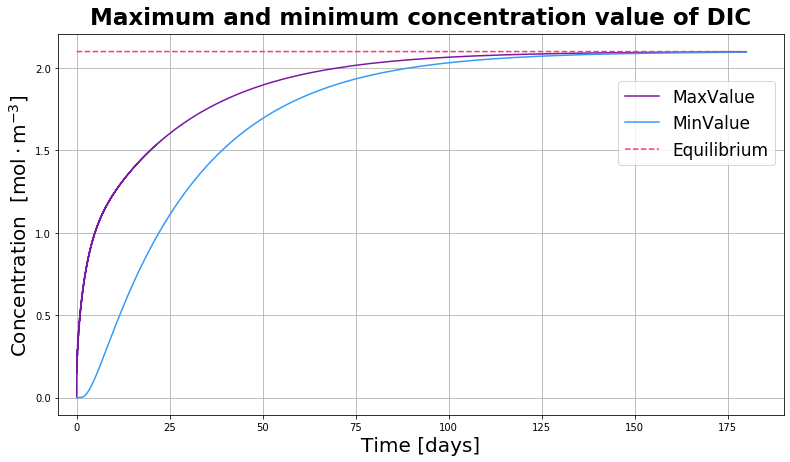

In [82]:
maxmin()

<font size="3"> We can clearly see that both the maximum and the minimum value of DIC approaches the equilibrium concentration. As expected the maximum value approaches the equilibrium earlier then the minimum value and follows a logarithmic curve. </font>

--------------

## Task:

<font size="4">• Plot also the concentration as a function of depth, for some different times, and discuss what you see. </font>

------

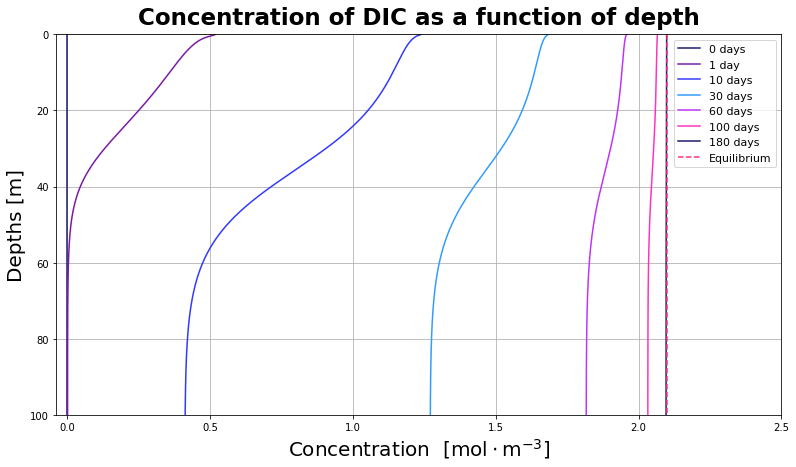

In [83]:
sim1()

<font size="3">Here the plot shows the concentration as function of depth at some different times. What we can observe is that the concentraction changes quite rapidly during the first days of the simulation, and slows down the closer it gets to the equilibrium. The reason for this is that the differences in concentration in both the atmosphere and within the ocean decreases, which implies that the distribution of concentration also will stagnate.</font>

------

## Task:

<font size="4">• Considering that the level of CO2 in the atmosphere changes only slowly from year to year (see
Fig. 3), would you say that the water at 100m depth is "in sync" with the changes in the atmosphere? </font>

------

<font size="3">We see from the plot that the concentration through the layer lags, meaning that the shallower depths changes quicker than at lower. But as we also see from the plot the level of C02 in the ocean changes quite rapidly and will clearly reach equilibrium with the atmosphere during the first 180 days. Therefore an incremental yearly change of the concentration of $CO_{2}$ in the atmosphere would spread realatively quickly down the water column. Thus we can argue that this layer of the ocean is "in sync" with the change in atmospheric concentration.</font>

------

# Problem 2
## CO2 absorption by the deep ocean


<font size = 3>

In this problem we are to estimate the amount of CO2 absorbed by the ocean annually, taking the yearly increase of CO2 in the atmosphere into account. There are several ways of storing CO2 in the ocean, but in this problem we only look at the quantity of CO2 stored in the ocean due to dissolution and mass transfer. We also look at the diffusivity of the DIC down to the depth of 4000 meters below sea level. The diffusivity model uses a sigmoid function that gives a high diffusivity in the mixed upper layer and lower values at greater depths.</font>

In [93]:

# Runs simulation for problem 2.

def sim2():
    
    # Defines variables and arrays as in Problem 1, but with a few changes commented bellow.
    
    L = 4000           # New depth.
    N = 1000 
    T = 5000
    H = 5060
    year = 10          # Number of years. 
    K = Diff_2(L,N)    # New diffusivity.
    t = year*365*24*3600
    pco2_0 = 415*10**(-6)
    C_eq0 = pco2_0*H 
    time = np.linspace(0, t, T)
    
    z = np.linspace(0,L,N+1)
    dz = z[1]-z[0]
    dt = time[1]-time[0] 
    alpha = dt/(2*(dz)**2)
    k_w = 6.97*10**(-5)
    gamma = 2*alpha*k_w*dz*(1-(K[1]-K[0])/(2*K[0]))
    
    #Creates flux matrix S, but now with an annualy concentration change taken into account.
    S = create_S(2.3*10**(-6),year,T,N,pco2_0,gamma)
    
    # Creates initial, equilibrium concentration array.
    C_start = np.ones(N+1)*C_eq0
    
    # Solves eq. (23) using diff_solver.
    concentration2 = diff_solver(K, C_start, S, T, N, alpha, gamma)
    
    # Plots the concentration as a function of depth for given times.
    fig, (fig1,fig2) = plt.subplots(1,2, figsize = (15,6))
    fig1.plot(concentration2[0],-z, color = "#2abf95", label = "0 years")
    fig1.plot(concentration2[1250],-z, color = "#3239fc", label = "2.5 years")
    fig1.plot(concentration2[2500],-z, color = "#329bfc", label = "5 years")
    fig1.plot(concentration2[5000],-z, color = "#bf32fc", label = "10 years")
    fig1.set(xlabel="Concentration  [$\mathrm{mol} \cdot \mathrm{m}^{-3}$]", ylabel= "Depth [m]")
    fig1.legend(prop={"size":15})
    
    # Plots the concentration as a function of depth for the top 600 meters.
    
    fig2.plot(concentration2[0][:150],-z[:150], color = "#2abf95", label = "0 years" )
    fig2.plot(concentration2[1250][:150],-z[:150], color = "#3239fc", label = "2.5 years" )
    fig2.plot(concentration2[2500][:150],-z[:150], color = "#329bfc", label = "5 years" )
    fig2.plot(concentration2[5000][:150],-z[:150], color = "#bf32fc", label = "10 years" )
    fig2.set(xlabel="Concentration  [$\mathrm{mol} \cdot \mathrm{m}^{-3}$]", ylabel= "Depth [m]")
    fig2.legend(prop={"size":15})
    
    fig.suptitle('Concentration of DIC as a function of depth', size = 23 ,fontweight = 'bold')
    plt.show()
    
def calculateMass():

    #Defines variables and initial conditions
    L = 4000
    N = 1000
    T = 5000
    year = 10
    K = Diff_2(L,N)
    t = year*365*24*3600 + 2*24*3600 # With added leapyear
    pco2_0 = 415*10**(-6)
    C_eq0 = pco2_0*5060
    time = np.linspace(0, t, T)
    
    z = np.linspace(0,L,N+1)
    dz = z[1]-z[0]
    dt = time[1]-time[0]
    alpha = dt/(2*(dz)**2)
    k_w = 6.97*10**(-5)
    gamma = 2*alpha*k_w*dz*(1-(K[1]-K[0])/(2*K[0]))
    S = create_S(2.3*10**(-6),year,T,N,pco2_0,gamma)
    
    C_start = np.zeros(N+1)
    for i in range(len(C_start)):
        C_start[i]=C_eq0
    
    concentration2 = diff_solver(K, C_start, S,T,N,alpha,gamma) #Solves eq. (23)
    
    #Calculates the mass in ocean
    mass = np.zeros(T)                                            
    
    for i in range(len(mass)):
        mass[i] = massInOcean2(concentration2[i],z)
        
    dager = time/(24*3600*365)
    massInTonne = mass
    
    # Plots the mass as function of time.
    plt.figure(6, figsize = (13,7))
    plt.plot(dager,massInTonne, linewidth = 3)
    plt.title("Total mass of DIC in the ocean from 2020 to 2030", size = 23 ,fontweight = 'bold')
    plt.xlabel("Time [Years]", size = 20)
    plt.ylabel("Mass [g]", size = 20)
    plt.grid()
    plt.show()
    
    massAbs = (mass[-1]-mass[0])/10
    
    
    print("Average mass absorbed by the ocean yearly from 2020 to 2030 is ", massAbs, "grams of CO2")


# Calculates the mass of DIC in the ocean.
def massInOcean2(conc, z):
    
    gramsPerMolarMass = 12 
    
    oceanSurf = 360*10**(12) # Total area of the ocean surface.
    
    mass = simps(conc,z)*oceanSurf*gramsPerMolarMass # Calculates the mass using scipys simpsons method.
    
    return mass # Returns the mass. 


--------

## Task:

<font size="4">• Plot the concentration as a function of depth, for the times 0, 2.5, 5 and 10 years into the simulation.
Comment on the results, in light of the illustration in Fig. 2.</font>

----

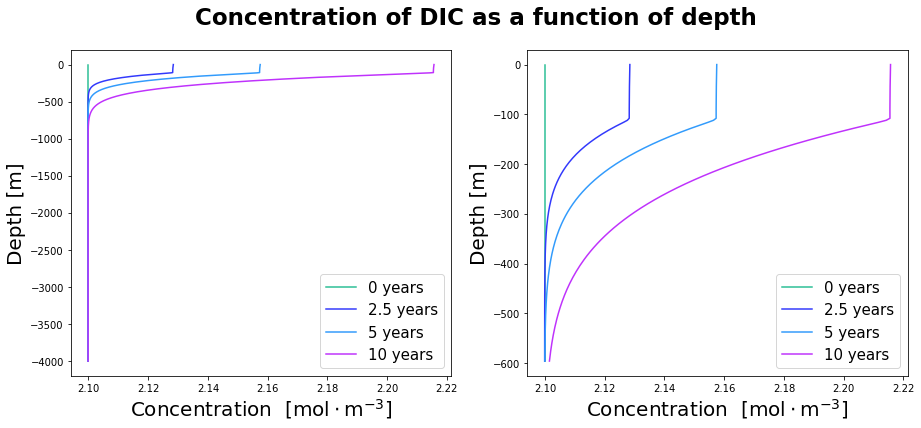

In [85]:
sim2()

<font size="3">We can see that the mixed layer of the ocean where the diffusivity is much higher, the concentration remains "in sync" with the atmospheric increase. Further down the oceanic concentration lags behind the atmospheric significantly and the change will not even surpass past 600m after 10 years. So the lag in the deep ocean is much more significant than in the mixed layer. This makes our estimate that the entire water column starts at uniform concentration questionable, because the atmospheric value of 415 ppm has not been a constant in the years prior, but has been rising steadily for the past 50 years. One can excpect the lower parts of the ocean to still hold concentrations that resemble pre-industrial times, and this will clearly effect our later estimate for the amount of C02 in the ocean. </font>

-----

## Task:

<font size="4">• Plot the total mass of DIC in the global oceans, as a function of time, for the years 2020 - 2030. The
total area of the global oceans is $360\cdot 10^{12} m^2$, and the atomic mass of carbon is 12 grams per
mole. We only count the mass of the carbon atoms, not the other elements involved. All of the DIC
molecules and ions have exactly one atom of carbon each.

• Find the amount of $CO_2$ absorbed by the entire global ocean in a year by looking at the mass in the
water column at the start of the simulation, compared to the mass at the end of the simulation, and
take the average over the 10 years. </font>

-----

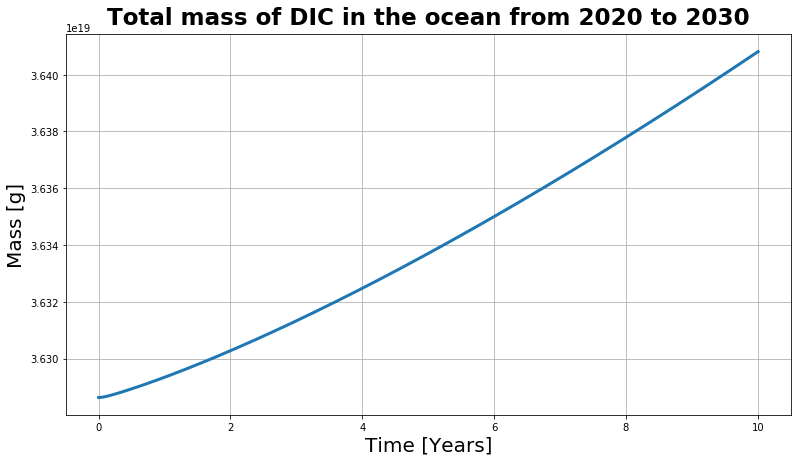

Average mass absorbed by the ocean yearly from 2020 to 2030 is  1.2184153203587072e+16 grams of CO2


In [90]:
calculateMass()

--------

## Task:

<font size="4">• Researchers have estimated that the oceans absorb so-called "anthropogenic CO2" at a rate of
about $2.5 \cdot 10^{15}$ g per year (Gruber et al., 2019). Anthropogenic refers to CO2 produced by human
activities, and essentially means that they have calculated how much CO2 the ocean absorbs in
addition to what it would have done, had the CO2 concentration remained at pre-industrial levels.
Comment on how your answer relates to the number found by Gruber et al. (2019), in light of the
simpliffcations we have made, and the number of processes we have ignored in formulating our
model. </font>

   ------
   
   

<font size="3"> Our value of the estimated annual mass absorbtion is $ 1.22\cdot10^{16}$ grams. This is roughly a factor of five higher then the value found in Gruber et al. (2019). There are several significant simplifications that decrease the accuracy of our estimate.

One of these is the assumption that the concentration in the ocean is initially at en equilibrium with the atmosphere. The concentration will in fact have a lower value deeper down in the ocean then the equilibrium value as mentioned earlier. If this would have been taken into account, the calculated absorbtion of DIC would be bigger. This is due to the initial difference in concentration for each depthstep being bigger then what we use in our estimate. However the effect on this assumption is limited by the small value of the diffusivity in the deeper ocean. This we can see from equation (2).

Another simplification is the estimated diffusivity function. Conditions such as weather, time of the year and ocean streams will affect the diffusivity in the ocean around the globe. This we can clearly see in the Gruber et al. (2019)[2] where they have mapped the differences in change of DIC in the ocean from 1994 to 2007 in different oceans.

We also assume that everything is constant in the horizontal plane, making it a one dimensional problem. Though this is a large assumption which decreases our estimates accuracy drasticly, it is still applicable to specific parts of the ocean.

There are several assumptions made associated with the flux of CO2 at the ocean surface. We assume that when CO2 enters the ocean it immedietly transforms into DIC, while this in fact will take some time. Further more we assume that the relationship between the partial preassure of CO2 in the atmosphere and the equilibrium concentration of DIC in the ocean is linear. This will in fact decay slightly as the average temperature of the ocean will rise with the increase of partial preassure of CO2. This is due to $CO_2$ being a greenhouse gas and the resulting decrease of solubility in water with increasing temperatures.[3]

Other assumptions not being accounted for are the prensence of plants and organisms, a constant average wind of 10 m/s and an average depth of 4000 meters.[4]

Taking all of these simplifications into account, the accuracy of our value for the yearly mass absorbed of DIC in the ocean is reduced drasticly. This is mostly due to the highly simplified diffusivity function as well as several flux simplifications mentioned over. However our value is approxamitly within a factor of 5 of the number found in in Gruber et al. (2019), which is within the boundary of what we can call a reasonable result and a well reasoned estimate. </font>



# References



<font size="3">
    
[1] Project 1: Nordam, Tor. (Project booklet)

[2] N. Gruber, D. Clement, B. R. Carter, R. A. Feely, S. Van Heuven, M. Hoppema, M. Ishii, R. M. Key,
A. Kozyr, S. K. Lauvset, et al. The oceanic sink for anthropogenic CO2 from 1994 to 2007. Science,
363(6432):1193{1199, 2019. https://science.sciencemag.org/content/sci/363/6432/1193.full.pdf

[3] SI Chemical Data, Blackman & Gahan, 7th edition, Wiley. Page 150, table 46.

[4] https://oceanservice.noaa.gov/facts/oceandepth.html


</font>